In [38]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

def df_to_sf(df):
    df['path'] = df['path'].apply(lambda x: x.split(':')[-1])
    df = df[['path', 'Strongest', 'Strong', 'Weak', 'Weakest', "Super_Weak"]]
    # df.iloc[:, 1:] = df.iloc[:, 1:].astype(int)

    return df

In [39]:
n = 2
m = 2

df_gencat = df_to_sf(pd.read_csv(f'outputs/GenCAT/Planetoid:Cora/network_category_n_{n}_m_{m}.csv').rename(columns={"Unnamed: 0": "path"}))
df_unatt = df_to_sf(pd.read_csv(f'outputs/UnAtt/Planetoid:Cora/network_category_n_{n}_m_{m}.csv').rename(columns={"Unnamed: 0": "path"}))
df_original = df_to_sf(pd.read_csv(f'outputs/Planetoid:Cora/network_category_n_0_m_0.csv').rename(columns={"Unnamed: 0": "path"}))
try:
    df_skymap =  df_to_sf(pd.read_csv(f'outputs/SkyMap/Planetoid:Cora/network_category_n_{0}_m_{0}.csv').rename(columns={"Unnamed: 0": "path"}))
except:
    df_skymap =  df_to_sf(pd.read_csv(f'outputs/SkyMap/Planetoid:Cora/network_category_n_0_m_0.csv').rename(columns={"Unnamed: 0": "path"}))

# df_gencat

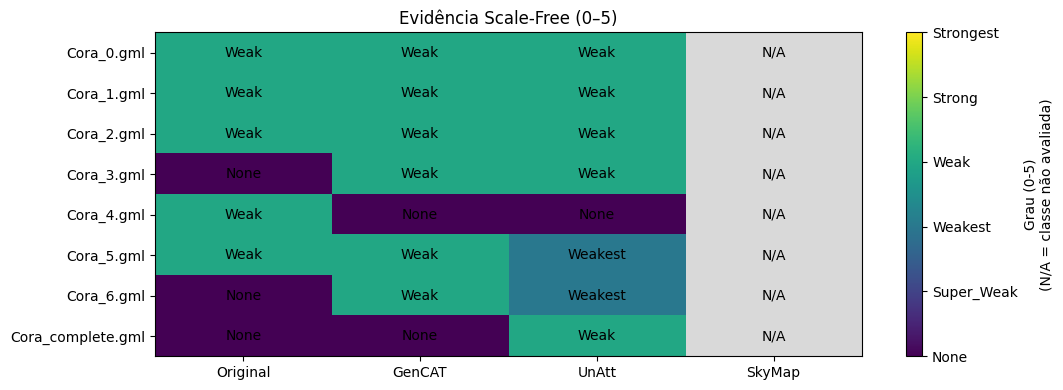

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- ajuste aqui se precisar ---
RANK  = ["Super_Weak", "Weakest", "Weak", "Strong", "Strongest"]
SCORE = {"None": 0, "Super_Weak": 1, "Weakest": 2, "Weak": 3, "Strong": 4, "Strongest": 5}
TICKLABELS = ["None","Super_Weak","Weakest","Weak","Strong","Strongest"]

def classify_row(row):
    # pega o maior nível (mais forte) entre as colunas booleanas
    for col in reversed(RANK):  # Strongest -> ... -> Super_Weak
        if col in row and bool(row[col]):
            return col
    return "None"

def ensure_final_class(df):
    # se já existir 'classificação_final', usa; senão calcula a partir dos booleans
    if "classificação_final" not in df.columns:
        df = df.copy()
        df["classificação_final"] = df.apply(classify_row, axis=1)
    return df[["path", "classificação_final"]].copy()

def to_score_keep_nan(series):
    """
    Converte rótulos -> escore (0–5), **preservando NaN**.
    - 'None' vira 0
    - linhas ausentes (NaN) continuam NaN (para virar 'N/A' no heatmap)
    """
    s = series.map(SCORE).astype("float")  # não usa fillna aqui!
    return s

def build_heatmap(df_original, df_gencat, df_unatt, df_skymap,
                  title="Evidência Scale-Free (0–5)"):
    sources = [
        ("Original", df_original),
        ("GenCAT",   df_gencat),
        ("UnAtt",    df_unatt),
        ("SkyMap",   df_skymap),
    ]

    frames = []
    for name, df in sources:
        tmp = ensure_final_class(df).rename(columns={"classificação_final": name})
        frames.append(tmp)

    # junta por 'path'
    base = frames[0]
    for tmp in frames[1:]:
        base = base.merge(tmp, on="path", how="outer")

    # ordenar paths numericamente se houver padrão ..._123.gml
    def _key(p):
        import re
        m = re.search(r'(\d+)', str(p))
        return (str(p), int(m.group(1))) if m else (str(p), -1)
    base = base.sort_values(by="path", key=lambda s: s.map(_key))

    col_names = [name for name, _ in sources]

    # matriz numérica 0–5 preservando NaN para "classe não avaliada"
    vals = np.column_stack([to_score_keep_nan(base[name]) for name in col_names])

    fig, ax = plt.subplots(figsize=(1.7*len(col_names)+4, max(4, 0.45 * len(base))))

    # Colormap que destaca NaN como cinza
    cmap = plt.cm.viridis.copy()
    cmap.set_bad("#D9D9D9")  # cor para NaN (classe ausente/N/A)

    im = ax.imshow(vals, aspect="auto", cmap=cmap, vmin=0, vmax=5)

    # ticks e rótulos
    ax.set_xticks(np.arange(len(col_names)))
    ax.set_xticklabels(col_names)
    ax.set_yticks(np.arange(len(base)))
    ax.set_yticklabels(base["path"])

    # anotação: 'N/A' se célula é NaN; senão o rótulo textual
    inv_score = {v: k for k, v in SCORE.items()}
    for i in range(vals.shape[0]):
        for j in range(vals.shape[1]):
            label_txt = base.iloc[i][col_names[j]]
            txt = "N/A" if pd.isna(label_txt) else str(label_txt)
            ax.text(j, i, txt, ha="center", va="center")

    ax.set_title(title)

    # colorbar com rótulos discretos
    cbar = plt.colorbar(im, ax=ax, ticks=np.arange(0, 6, 1))
    cbar.ax.set_yticklabels(TICKLABELS)
    cbar.set_label("Grau (0-5)\n(N/A = classe não avaliada)")

    plt.tight_layout()
    plt.show()

# Uso:
build_heatmap(df_original, df_gencat, df_unatt, df_skymap)


In [42]:
import networkx as nx


n = 2
m = 3
model = 'GenCAT'
cluster = 'Cora_complete'
# (tensor([0, 1, 2, 3, 4, 5, 6]), tensor([351, 217, 418, 818, 426, 298, 180]))

# G = nx.read_gml('datasets/UnAtt/Planetoid:Cora_n_0_m_0/gmls/Planetoid:Cora_6.gml')
# G = nx.read_gml('datasets/UnAtt/Planetoid:Cora_n_0_m_0/gmls/Planetoid:Cora_6.gml')
# G = nx.read_gml('datasets/Cora/gmls/Planetoid:Cora_6.gml')
# G = nx.read_gml('datasets/GenCAT/Planetoid:Cora_n_0_m_0/gmls/Planetoid:Cora_6.gml')

if model is not None:
    G = nx.read_gml(f'datasets/{model}/Planetoid:Cora_n_{n}_m_{m}/gmls/Planetoid:{cluster}.gml')

else:
    G = nx.read_gml(f'datasets/Cora/gmls/Planetoid:{cluster}.gml')


G = G.to_undirected()

print(len(G.nodes))
print(len(G.edges))

5416
31556


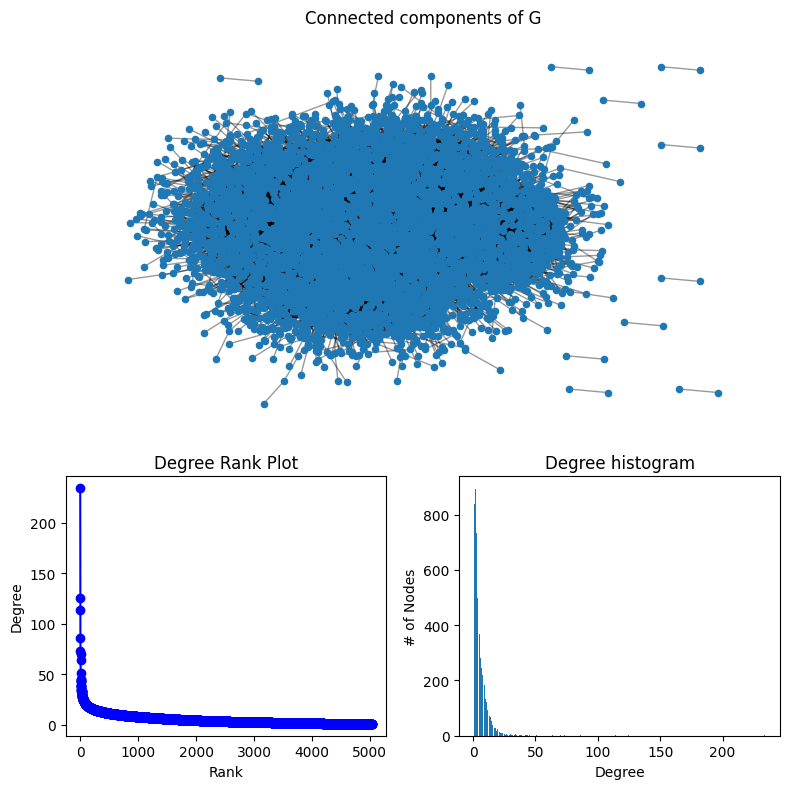

In [34]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
dmax = max(degree_sequence)

fig = plt.figure("Degree of a random graph", figsize=(8, 8))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 4)

ax0 = fig.add_subplot(axgrid[0:3, :])
# Gcc = G.subgraph(sorted(nx.connected_components(G), key=len, reverse=True)[0])
Gcc = G
# pos = nx.spring_layout(Gcc, seed=10396953)
pos = nx.nx_pydot.graphviz_layout(G)
nx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=20)
nx.draw_networkx_edges(Gcc, pos, ax=ax0, alpha=0.4)
ax0.set_title("Connected components of G")
ax0.set_axis_off()

ax1 = fig.add_subplot(axgrid[3:, :2])
ax1.plot(degree_sequence, "b-", marker="o")
ax1.set_title("Degree Rank Plot")
ax1.set_ylabel("Degree")
ax1.set_xlabel("Rank")

ax2 = fig.add_subplot(axgrid[3:, 2:])
ax2.bar(*np.unique(degree_sequence, return_counts=True))
ax2.set_title("Degree histogram")
ax2.set_xlabel("Degree")
ax2.set_ylabel("# of Nodes")

fig.tight_layout()

if model is None:
    plt.savefig(f'figures/output_{model}_{cluster}.png')
else:
    plt.savefig(f'figures/output_{model}_{cluster}_{n}_{m}.png')
plt.show()


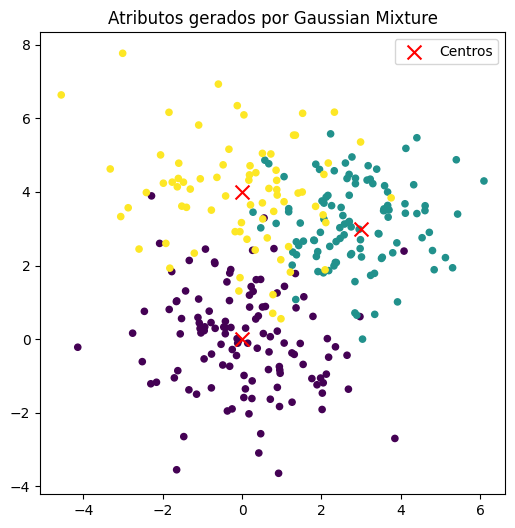

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

# Número de clusters e dimensões
K = 3
dim = 2
n_nodes = 300

# Definir "centros" manuais para cada cluster
means = np.array([[0, 0], [3, 3], [0, 4]])
covariances = [2*np.eye(dim), 1.5*np.eye(dim),2.3*np.eye(dim)]
weights = [0.4, 0.35, 0.25]  # distribuição dos clusters

# Gerar atributos usando Gaussian Mixture Model
X = []
labels = []

for k in range(K):
    n_k = int(weights[k] * n_nodes)
    cluster_points = np.random.multivariate_normal(means[k], covariances[k], n_k)
    X.append(cluster_points)
    labels.append(np.full(n_k, k))

X = np.vstack(X)
labels = np.concatenate(labels)

# Visualização
plt.figure(figsize=(6, 6))
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap="viridis", s=20)
plt.scatter(means[:, 0], means[:, 1], c="red", marker="x", s=100, label="Centros")
plt.title("Atributos gerados por Gaussian Mixture")
plt.legend()
plt.show()


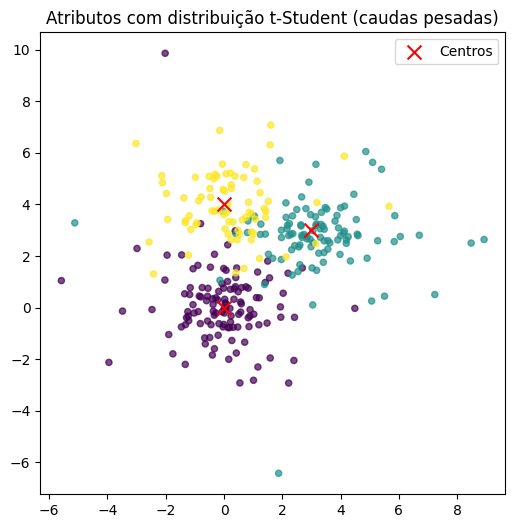

In [36]:
import numpy as np
import matplotlib.pyplot as plt

def multivariate_t_rvs(mean, cov, df, n=1):
    """
    Amostragem da distribuição t-Student multivariada.
    """
    d = len(mean)
    g = np.tile(np.random.gamma(df/2., 2./df, n), (d,1)).T  # escala do qui-quadrado
    Z = np.random.multivariate_normal(np.zeros(d), cov, n)
    return mean + Z/np.sqrt(g)

# Parâmetros
K = 3
dim = 2
n_nodes = 300
means = np.array([[0, 0], [3, 3], [0, 4]])
covariances = [0.8*np.eye(dim), 1.0*np.eye(dim), 0.9*np.eye(dim)]
weights = [0.4, 0.35, 0.25]
df = 3  # graus de liberdade -> caudas pesadas

# Gerar atributos com t-Student
X = []
labels = []

for k in range(K):
    n_k = int(weights[k] * n_nodes)
    cluster_points = multivariate_t_rvs(means[k], covariances[k], df, n=n_k)
    X.append(cluster_points)
    labels.append(np.full(n_k, k))

X = np.vstack(X)
labels = np.concatenate(labels)

# Visualização
plt.figure(figsize=(6, 6))
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap="viridis", s=20, alpha=0.7)
plt.scatter(means[:, 0], means[:, 1], c="red", marker="x", s=100, label="Centros")
plt.title("Atributos com distribuição t-Student (caudas pesadas)")
plt.legend()
plt.show()


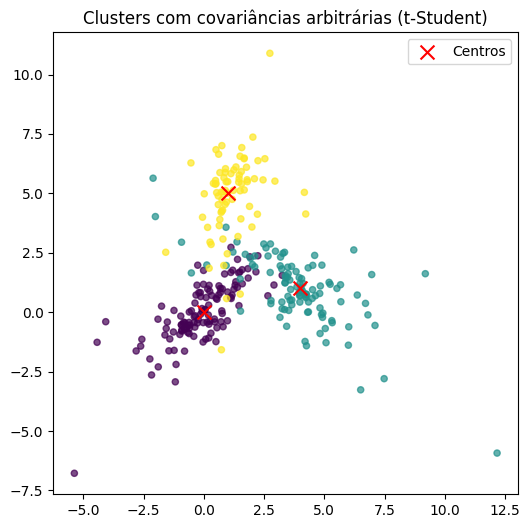

In [37]:
import numpy as np
import matplotlib.pyplot as plt

def multivariate_t_rvs(mean, cov, df, n=1):
    """
    Amostragem da distribuição t-Student multivariada.
    """
    d = len(mean)
    g = np.tile(np.random.gamma(df/2., 2./df, n), (d,1)).T
    Z = np.random.multivariate_normal(np.zeros(d), cov, n)
    return mean + Z/np.sqrt(g)

# Parâmetros
K = 3
dim = 2
n_nodes = 300
means = np.array([[0, 0], [4, 1], [1, 5]])

# Matrizes de covariância NÃO diagonais
covariances = [
    np.array([[1.0, 0.8], [0.8, 1.0]]),   # alta correlação positiva
    np.array([[1.5, -0.7], [-0.7, 1.0]]), # correlação negativa
    np.array([[0.5, 0.2], [0.2, 1.2]])    # covariância assimétrica
]

weights = [0.4, 0.35, 0.25]
df = 4  # graus de liberdade (caudas pesadas moderadas)

# Gerar atributos
X, labels = [], []

for k in range(K):
    n_k = int(weights[k] * n_nodes)
    cluster_points = multivariate_t_rvs(means[k], covariances[k], df, n=n_k)
    X.append(cluster_points)
    labels.append(np.full(n_k, k))

X = np.vstack(X)
labels = np.concatenate(labels)

# Visualização
plt.figure(figsize=(6, 6))
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap="viridis", s=20, alpha=0.7)
plt.scatter(means[:, 0], means[:, 1], c="red", marker="x", s=100, label="Centros")
plt.title("Clusters com covariâncias arbitrárias (t-Student)")
plt.legend()
plt.show()
